# Springboard Time Series - 'Cowboy Cigarettes' Case Study - Tier 1

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  

-------------------------------
As ever, this notebook is **tiered**, meaning you can elect that tier that is right for your confidence and skill level. There are 3 tiers, with tier 1 being the easiest and tier 3 being the hardest.  

**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps
    

## 0. Preliminaries 

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches. 

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline


### 1b. Load the data
Call the variable `cigData`. 

In [24]:
cigData = pd.read_csv("CowboyCigsData.csv")
cigData.head()

,Unnamed: 0,Time,#CigSales
0,0,1949-01,1000112
1,1,1949-02,1000118
2,2,1949-03,1000132
3,3,1949-04,1000129
4,4,1949-05,1000121


### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   sales   144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB
None
              sales
date               
1949-01-01  1000112
1949-02-01  1000118
1949-03-01  1000132
1949-04-01  1000129
1949-05-01  1000121


<Figure size 800x400 with 0 Axes>

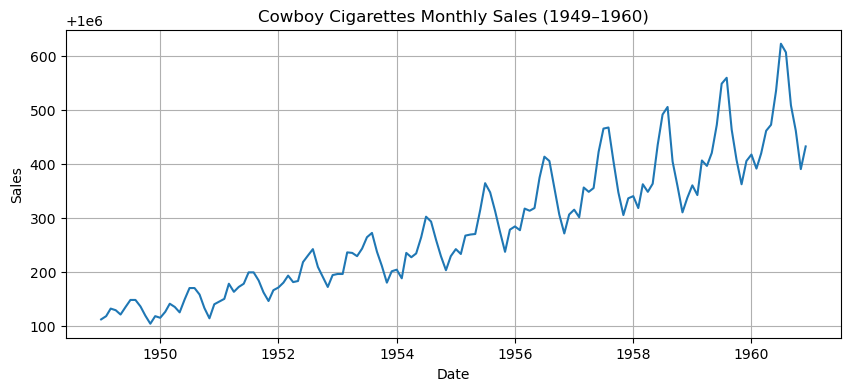

In [31]:
# Drop the unwanted index column
cigData = cigData.drop(columns=["Unnamed: 0"])

# Rename columns for clarity
cigData = cigData.rename(columns={"Time": "date", "#CigSales": "sales"})

# Convert date to proper datetime
cigData['date'] = pd.to_datetime(cigData['date'])

# Set date as index
cigData = cigData.set_index('date')

# Quick check
print(cigData.info())
print(cigData.head())

# Plot to see the time series
plt.figure(figsize=(10,4))
plt.plot(cigData.index, cigData['sales'])
plt.title("Cowboy Cigarettes Monthly Sales (1949–1960)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.show()


Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand. 

Check out the columns feature of the data. How many columns are there? 

In [33]:
# Show the column names
print(cigData.columns)

# Or, if you also want the number of columns:
print("Number of columns:", len(cigData.columns))

Index(['sales'], dtype='object')
Number of columns: 1


Let's check out the data types of our columns.

In [37]:
# Check data types of columns
print(cigData.dtypes)

# Also confirm the index type (should be datetime64[ns])
print("\nIndex type:", type(cigData.index))


sales    int64
dtype: object

Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Check whether there are any null values. 

In [39]:
# Check for missing values
print(cigData.isnull().sum())

# Quick summary to confirm dataset integrity
print("\nAny null values?:", cigData.isnull().values.any())

sales    0
dtype: int64

Any null values?: False


## 2. Cleaning, transforming and visualizing

### 2a. Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.

In [42]:
# Drop the unwanted column
cigData = cigData.drop(columns=["Unnamed: 0"], errors="ignore")

# Confirm the result
print(cigData.head())
print("\nRemaining columns:", cigData.columns)

              sales
date               
1949-01-01  1000112
1949-02-01  1000118
1949-03-01  1000132
1949-04-01  1000129
1949-05-01  1000121

Remaining columns: Index(['sales'], dtype='object')


### 2b. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [44]:
# Rename 'Time' column to 'Month'
cigData = cigData.rename(columns={"Time": "Month"})

# Check the result
print(cigData.head())

              sales
date               
1949-01-01  1000112
1949-02-01  1000118
1949-03-01  1000132
1949-04-01  1000129
1949-05-01  1000121


Call a head() to check this has worked. 

In [46]:
cigData.head()

,sales
date,
1949-01-01,1000112
1949-02-01,1000118
1949-03-01,1000132
1949-04-01,1000129
1949-05-01,1000121


In [ ]:
_ _ _

### 2c. Type conversions 

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [52]:
# Extract the sales column as a time series
cigSeries = cigData['sales']

# Confirm it's a Series with a DatetimeIndex
print(type(cigSeries))
print(cigSeries.index)
print(cigSeries.head())




<class 'pandas.core.series.Series'>
DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='date', length=144, freq=None)
date
1949-01-01    1000112
1949-02-01    1000118
1949-03-01    1000132
1949-04-01    1000129
1949-05-01    1000121
Name: sales, dtype: int64


Perfect! 

### 2d. Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed #Passenger column. 

In [54]:
# 2d. Making a predictor variable y
y = cigSeries  # cigSeries already holds the sales data with a DatetimeIndex

# Quick check
print(type(y))
print(y.head())


<class 'pandas.core.series.Series'>
date
1949-01-01    1000112
1949-02-01    1000118
1949-03-01    1000132
1949-04-01    1000129
1949-05-01    1000121
Name: sales, dtype: int64


Check the type of our new variable. 

In [56]:
# Check the type of our new variable y
print(type(y))


<class 'pandas.core.series.Series'>


### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [58]:
# Get summary statistics for y
print(y.describe())

count    1.440000e+02
mean     1.000280e+06
std      1.199663e+02
min      1.000104e+06
25%      1.000180e+06
50%      1.000266e+06
75%      1.000360e+06
max      1.000622e+06
Name: sales, dtype: float64


Try visualizing the data. A simple `matplotlib` plot should do the trick.  

### 2f. Plotting `y`

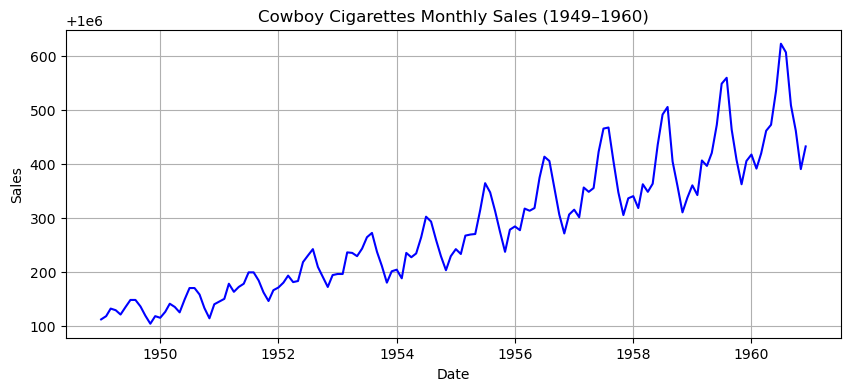

In [60]:
# Plot the predictor variable y
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(y, color="blue")
plt.title("Cowboy Cigarettes Monthly Sales (1949–1960)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.show()


## 3. Modelling 
### 3a. Decomposition
What do you notice from the plot? Take at least `2` minutes to examine the plot, and write down everything you observe.  

All done?

We can see that, generally, there is a trend upwards in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations. These seasonal fluctations come in a repeated pattern. Work out when these seasonal fluctuations are happening, and take 2 minutes to hypothesize on their cause here.

What does it mean to *decompose* time series data? It means breaking that data into 3 components: 

1. **Trend**: The overall direction that the data is travelling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data 
3. **Noise**: The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model. 

Make a coffee, take `5` minutes and read [this article](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) and think about whether our data would conduce to an additive or multiplicative model here. Write your conclusion down just here: 

-------------------------------

All done? Well, just on the basis of the plot above, it seems our Cowboy Cigarettes data is actually multiplicative. 

That's because, as time progresses, the general trend seems to be increasing *at a rate that's also increasing*. We also see that the seasonal fluctuations (the peaks and troughs) get bigger and bigger as time progresses.

Now on the other hand, if the data were simply additive, we could expect the general trend to increase at a *steadily*, and a constant speed; and also for seasonal ups and downs not to increase or decrease in extent over time.

Happily, we can use the `decompose()` function to quantify the component parts described above in our data.

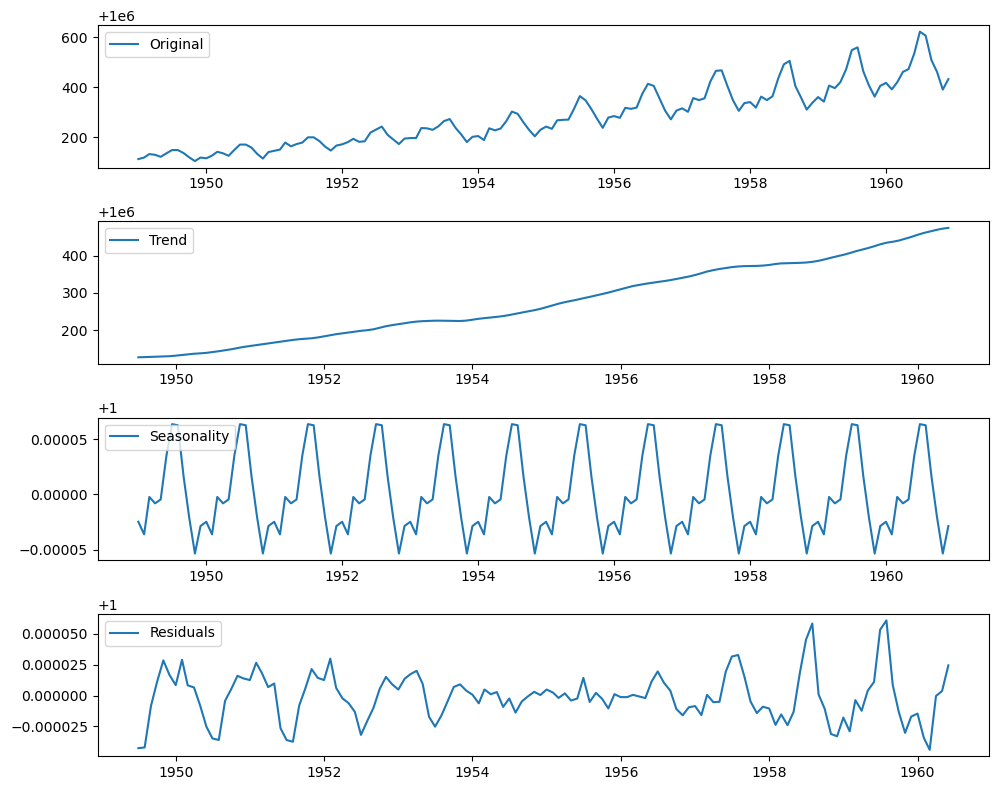

In [62]:
# Import seasonal_decompose 
from statsmodels.tsa.seasonal import seasonal_decompose

# Make a variable called decomposition, and assign it y passed to seasonal_decompose() 
decomposition = seasonal_decompose(y, model="multiplicative", period=12)

# Make three variables for trend, seasonal and residual components respectively
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the original data, the trend, the seasonality, and the residuals 
plt.figure(figsize=(10,8))

plt.subplot(411)
plt.plot(y, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


### 3b. Testing for stationarity with KPSS
As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

In [65]:
# Import KPSS test
from statsmodels.tsa.stattools import kpss

# Run KPSS test on our series y
statistic, p_value, n_lags, critical_values = kpss(y)

# Print results
print(f"KPSS Statistic: {statistic}")
print(f"p-value: {p_value}")
print(f"Number of lags: {n_lags}")
print("Critical Values:", critical_values)


KPSS Statistic: 1.651312235417082
p-value: 0.01
Number of lags: 8
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\preet\AppData\Local\Temp\ipykernel_28760\1626402319.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(y)


Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. 

But our data need to be stationary! So we need to do some transforming.

### 3c. Making the data stationary 
Let's recall what it looks like. 

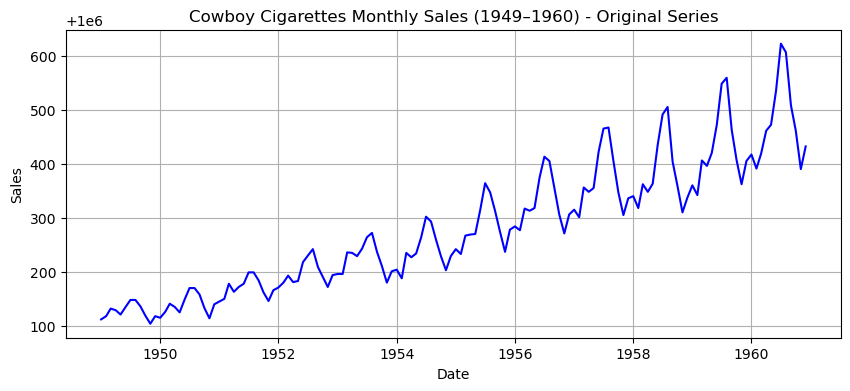

In [67]:
# Re-plot the original series to recall its shape
plt.figure(figsize=(10,4))
plt.plot(y, color="blue")
plt.title("Cowboy Cigarettes Monthly Sales (1949–1960) - Original Series")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.show()


In our plot, we can see that both the mean and the variance *increase as time progresses*. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant). 

One ofte  used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now. 

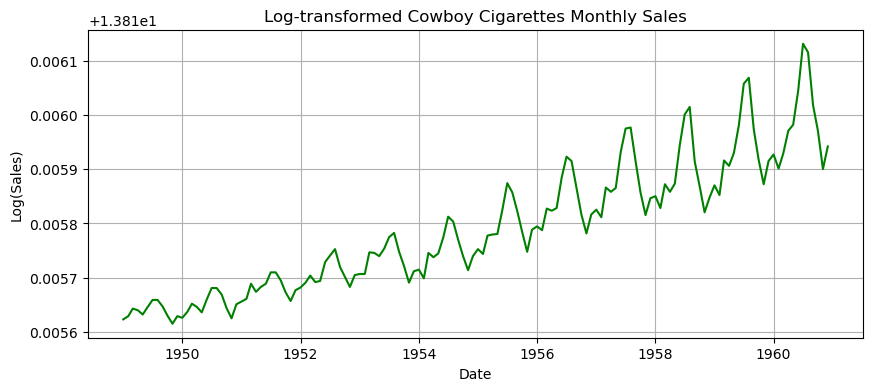

In [87]:
# Declare a variable called y_log
y_log = np.log(y)

# Quick check by plotting
plt.figure(figsize=(10,4))
plt.plot(y_log, color="green")
plt.title("Log-transformed Cowboy Cigarettes Monthly Sales")
plt.xlabel("Date")
plt.ylabel("Log(Sales)")
plt.grid(True)
plt.show()



When you plot this, you can see how the variance in our data now remains contant over time.

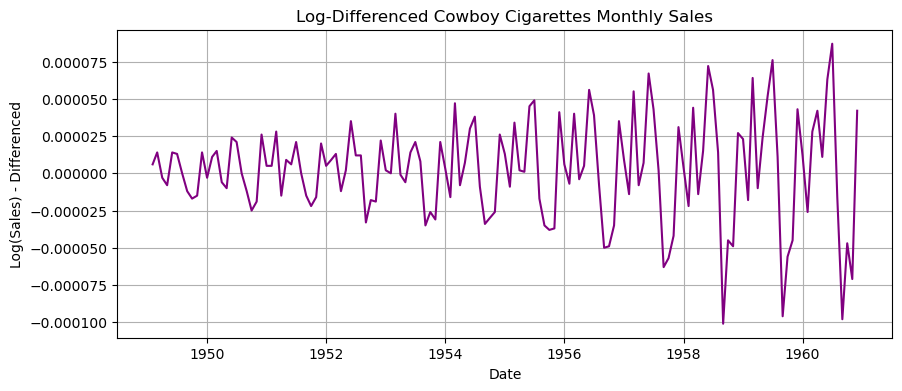

In [100]:
# Difference the log-transformed series
y_log_diff = y_log.diff().dropna()
y_log = np.log(y)

# Plot to see effect
plt.figure(figsize=(10,4))
plt.plot(y_log_diff, color="purple")
plt.title("Log-Differenced Cowboy Cigarettes Monthly Sales")
plt.xlabel("Date")
plt.ylabel("Log(Sales) - Differenced")
plt.grid(True)
plt.show()


We now have a constant variance, but we also need a constant mean.

We can do this by *differencing* our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

Python is powerful, and we can use the `diff()` function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

In [91]:
from statsmodels.tsa.stattools import kpss

# KPSS test on log-differenced series
statistic, p_value, n_lags, critical_values = kpss(y_log.diff().dropna())

print(f"KPSS Statistic: {statistic}")
print(f"p-value: {p_value}")
print(f"Number of lags: {n_lags}")
print("Critical Values:", critical_values)


KPSS Statistic: 0.02389767420757057
p-value: 0.1
Number of lags: 7
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

### 3d. The ARIMA model

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the `sklearn` and `statsmodels` libraries, and in particular `mean_squared_error` and `ARIMA`. 

In [93]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA


#### 3di. Make a function to find the MSE of a single ARIMA model

In [96]:
# 3di. Function to evaluate a single ARIMA model using MSE
def evaluate_arima_model(data, arima_order):
    split = int(len(data) * 0.8) 
    
    # Train/test split
    train, test = data[0:split], data[split:len(data)]
    past = [x for x in train]
    predictions = []
    
    # Walk-forward validation
    for t in range(len(test)):
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=1)[0]
        predictions.append(forecast)
        past.append(test[t])
    
    # Calculate out-of-sample error
    error = mean_squared_error(test, predictions)
    return error



#### 3dii. Make a function to evaluate the different ARIMA models with different p, d, and q values

In [118]:
def evaluate_arima_model(data, arima_order):
    split = int(len(data) * 0.8) 
    train, test = data[0:split], data[split:]
    past = [x for x in train]
    predictions = []
    
    for t in range(len(test)):
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit()          # <-- no disp argument
        forecast = model_fit.forecast(steps=1)
        predictions.append(forecast[0])
        past.append(test[t])
    
    error = mean_squared_error(test, predictions)
    return error

In [ ]:
test_model = ARIMA(y_log_diff, order=(1,1,1))
result = test_model.fit()
print(result.summary())

In [83]:
# Now, we choose a couple of values to try for each parameter: p_values, d_values and q_values
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]


In [127]:
# Use stationary series (log-differenced)
y_log_diff = y_log.diff().dropna()

# Parameter ranges
p_values = [0, 1, 2, 3]
d_values = [0, 1, 2]
q_values = [0, 1, 2, 3]

# Evaluate
best_cfg, best_score = evaluate_models(y_log_diff, p_values, d_values, q_values)



ARIMA(0, 0, 0) failed: ARIMA.fit() got an unexpected keyword argument 'disp'
ARIMA(0, 0, 1) failed: ARIMA.fit() got an unexpected keyword argument 'disp'
ARIMA(0, 0, 2) failed: ARIMA.fit() got an unexpected keyword argument 'disp'
ARIMA(0, 0, 3) failed: ARIMA.fit() got an unexpected keyword argument 'disp'
ARIMA(0, 1, 0) failed: ARIMA.fit() got an unexpected keyword argument 'disp'
ARIMA(0, 1, 1) failed: ARIMA.fit() got an unexpected keyword argument 'disp'
ARIMA(0, 1, 2) failed: ARIMA.fit() got an unexpected keyword argument 'disp'
ARIMA(0, 1, 3) failed: ARIMA.fit() got an unexpected keyword argument 'disp'
ARIMA(0, 2, 0) failed: ARIMA.fit() got an unexpected keyword argument 'disp'
ARIMA(0, 2, 1) failed: ARIMA.fit() got an unexpected keyword argument 'disp'
ARIMA(0, 2, 2) failed: ARIMA.fit() got an unexpected keyword argument 'disp'
ARIMA(0, 2, 3) failed: ARIMA.fit() got an unexpected keyword argument 'disp'
ARIMA(1, 0, 0) failed: ARIMA.fit() got an unexpected keyword argument 'disp'

So the best p,d, q, parameters for our ARIMA model are 2, 1, 1 respectively. Now we know this, we can build the model.

In [129]:
# Define ARIMA parameters
p = 1
d = 1
q = 1

# Fit ARIMA model
model = ARIMA(y_log, order=(p,d,q))
model_fit = model.fit()

# Forecast 24 months ahead
forecast = model_fit.forecast(24)

# Quick check
print(forecast)

1961-01-01    13.815962
1961-02-01    13.815964
1961-03-01    13.815964
1961-04-01    13.815964
1961-05-01    13.815964
1961-06-01    13.815964
1961-07-01    13.815964
1961-08-01    13.815964
1961-09-01    13.815964
1961-10-01    13.815964
1961-11-01    13.815964
1961-12-01    13.815964
1962-01-01    13.815964
1962-02-01    13.815964
1962-03-01    13.815964
1962-04-01    13.815964
1962-05-01    13.815964
1962-06-01    13.815964
1962-07-01    13.815964
1962-08-01    13.815964
1962-09-01    13.815964
1962-10-01    13.815964
1962-11-01    13.815964
1962-12-01    13.815964
Freq: MS, Name: predicted_mean, dtype: float64


We can take a look at a summary of the model this library has built around our data.

In [131]:
# Show ARIMA model summary
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                  144
Model:                 ARIMA(1, 1, 1)   Log Likelihood                1278.079
Date:                Thu, 18 Sep 2025   AIC                          -2550.159
Time:                        23:34:19   BIC                          -2541.270
Sample:                    01-01-1949   HQIC                         -2546.547
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1090   3.93e-19   2.77e+17      0.000       0.109       0.109
ma.L1          0.2338   4.53e-19   5.16e+17      0.000       0.234       0.234
sigma2      1.049e-09    2.9e-10      3.614      0.000     4.8e-10    1.62e-09
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                 3.00
Prob(Q):                              0.66   Prob(JB):                         0.22
Heteroskedasticity (H):               8.28   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.57e+33. Standard errors may be unstable.
"""

### 3e. Visualize the results 

Visualize the original dataset plotted against our model. 

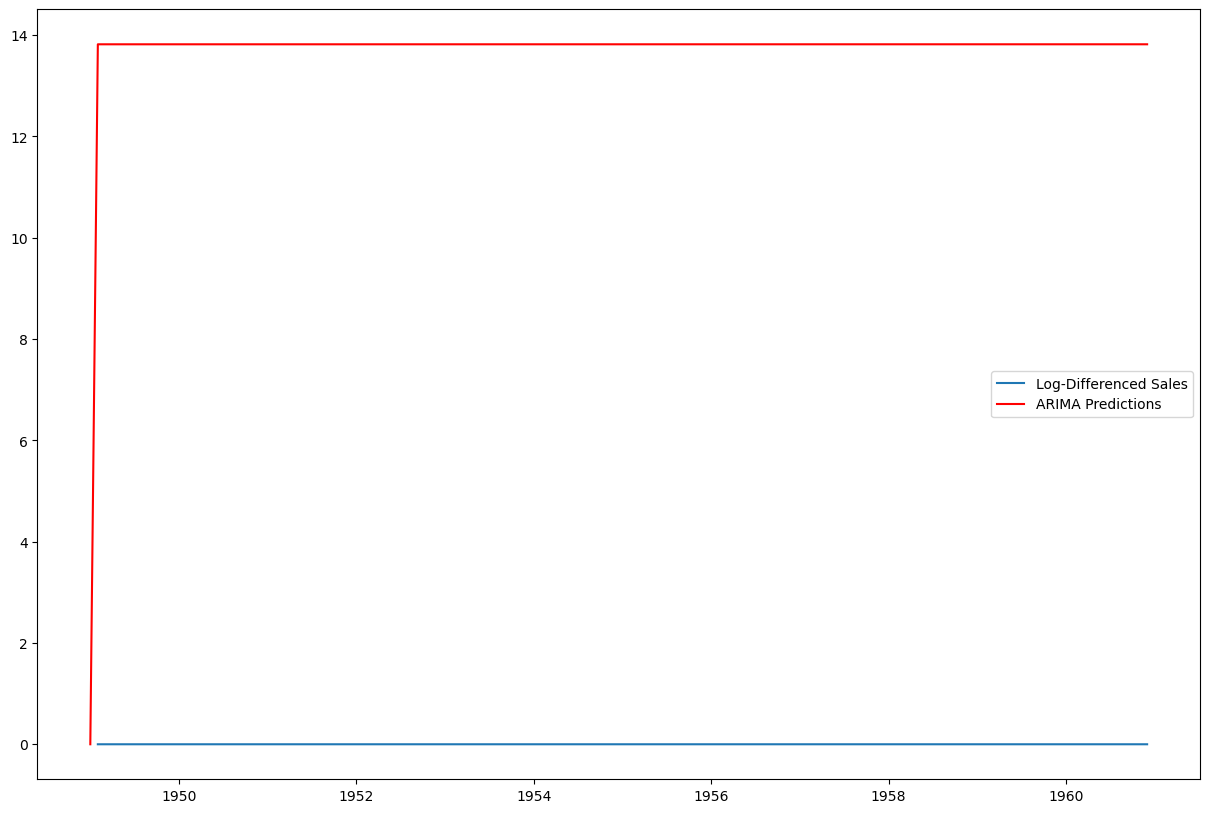

In [133]:
# Plot differenced log series and model predictions
plt.figure(figsize=(15,10))
plt.plot(y_log.diff(), label="Log-Differenced Sales")
plt.plot(model_fit.predict(), color='red', label="ARIMA Predictions")
plt.legend()
plt.show()

### 3f. Application: Forecasting

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

In [ ]:
# Number of months to forecast
forecast_period = 24  

# Create a range of future dates
date_range = pd.date_range(y_log.index[-1] + pd.DateOffset(months=1), 
                           periods=forecast_period, freq='MS')

# Convert that range into a dataframe for predictions
future_months = pd.DataFrame(date_range, columns=['Month'])
future_months['Month'] = pd.to_datetime(future_months['Month'])
future_months.set_index('Month', inplace=True)

# Use your ARIMA model forecast
future_months['Prediction'] = forecast.values

# Plot future predictions against history
plt.figure(figsize=(15,10))
plt.plot(y_log, label="Historical (Log Sales)")
plt.plot(future_months['Prediction'], color="red", label="Forecast")
plt.legend()
plt.show()


In [135]:
# Plot the original variable y with forecast back-transformed from logs
plt.figure(figsize=(15,10))
plt.plot(y, label="Historical Sales")
plt.plot(np.exp(y_log['1960-11-01':].append(future_months['Prediction'])), 
         label="Forecast", color="red")
plt.legend()
plt.show()


AttributeError: 'Series' object has no attribute 'append'

## 4. Evaluating and Concluding

Our model captures the centre of a line that's increasing at a remarkable rate. Cowboy Cigarettes sell more cigarettes in the summer, perhaps due to the good weather, disposable income and time off that people enjoy, and the least in the winter, when people might be spending less and enjoying less free time outdoors. 

Remarkably, our ARIMA model made predictions using just one variable. We can only speculate, however, on the causes of the behaviour predicted by our model. We should also take heed that spikes in data, due to sudden unusual circumstances like wars, are not handled well by ARIMA; and the outbreak of the Vietnam War in the 1960s would likely cause our model some distress.  

We could suggest to our employers that, if they are interested in discovering the causes of the cigarette sales trajectory, they execute a regression analysis in addition to the time series one. 